In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dhai-ecg-dataset/ecg_processed_data_2.csv
/kaggle/input/dhai-ecg-dataset-2/ecg_processed_test.csv
/kaggle/input/dhai-ecg-dataset-2/ecg_processed_train.csv


In [2]:
import os
import itertools
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
%matplotlib inline

In [4]:
ecg_path = "/kaggle/input/dhai-ecg-dataset/ecg_processed_data_2.csv"

In [5]:
ecg_data = pd.read_csv(ecg_path, index_col=0)

In [6]:
# t_df, test_df = train_test_split( ecg_data, test_size=0.2, random_state=42, stratify=ecg_data['acn'])
    
# t_df, test_df = t_df.reset_index(drop=True), test_df.reset_index(drop=True)

# t_df.to_csv("ecg_processed_train.csv", index=False)
# test_df.to_csv("ecg_processed_test.csv", index= False)

In [7]:
ecg_data.head()

,Segment Start,Segment End,xs0,xs1,xs2,xs3,xs4,xs5,xs6,xs7,...,xs193,xs194,xs195,xs196,xs197,xs198,xs199,Annotation Class,Annotation Class Numeric,acn
Record ID,,,,,,,,,,,,,,,,,,,,,
100,13,213,0.059449,0.055308,0.052035,0.049666,0.047961,0.046922,0.046801,0.047770,...,0.033233,0.033981,0.034276,0.034166,0.033702,0.033134,0.032648,N,1,0
100,307,507,0.084239,0.087566,0.088956,0.088621,0.086919,0.084459,0.081823,0.079506,...,0.020049,0.020272,0.020719,0.020971,0.020866,0.020622,0.020434,N,1,0
100,563,763,-0.006937,-0.005690,-0.005184,-0.005172,-0.005405,-0.005802,-0.006385,-0.007163,...,-0.084798,-0.084841,-0.084325,-0.082953,-0.080644,-0.077424,-0.073181,N,1,0
100,883,1083,0.072086,0.073128,0.073026,0.071802,0.069731,0.067336,0.065156,0.063624,...,0.040605,0.040177,0.039328,0.038051,0.036671,0.035565,0.034817,N,1,0
100,1168,1368,0.084762,0.083995,0.082327,0.080127,0.077701,0.075216,0.072963,0.071264,...,0.025977,0.027249,0.029211,0.031715,0.034364,0.036462,0.037443,N,1,0


In [8]:
ecg_data["Annotation Class"].unique()

array(['N', 'V', '/', 'L', 'R'], dtype=object)

In [9]:
id_to_label = {val: idx for idx, val in enumerate(list(ecg_data["Annotation Class"].unique()))}

In [10]:
x_columns = [f"xs{i}" for i in range(0, 200)]

In [11]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    attn_state_path = '/kaggle/working/attn.pth'
    lstm_state_path = '/kaggle/working/lstm.pth'
    cnn_state_path = '/kaggle/working/cnn.pth'
    
    attn_logs = '/kaggle/working/attn.csv'
    lstm_logs = '/kaggle/working/lstm.csv'
    cnn_logs = '/kaggle/working/cnn.csv'
    
    ecg_csv_path = '/kaggle/input/dhai-ecg-dataset/ecg_processed_data_2.csv'
    train_csv_path = '/kaggle/input/dhai-ecg-dataset-2/ecg_processed_train.csv'
    test_csv_path = '/kaggle/input/dhai-ecg-dataset-2/ecg_processed_test.csv'
    

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
config = Config()
seed_everything(config.seed)

In [12]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.X = torch.tensor(self.df.iloc[:,2:-3].values, dtype=torch.float32)
        self.y = torch.tensor(self.df.iloc[:,-1].values, dtype=torch.long) 

    def __getitem__(self, idx):
        signal = torch.reshape(self.X[idx],(1,200))
        target = self.y[idx]
        return signal, target

    def __len__(self):
        return len(self.df)

In [13]:
def get_dataloader(data_csv_path: str, phase: str, batch_size: int = 96) -> DataLoader:
    '''
    Dataset and DataLoader.
    Parameters:
        data_csv_path: processed_data path.
        phase: training, testing or validation phase.
        target: Annotation Class Numeric
        signal_cols: columns belonging to signal
        batch_size: data per iteration.
    Returns:
        data generator
    '''
    df = pd.read_csv(data_csv_path)
    
    train_df, val_df = train_test_split(df, test_size=0.25, random_state=42, stratify=df['acn'])

    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

    if phase == 'train':
        df = train_df
    elif phase == 'val':
        df = val_df

    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size)
    
    return dataloader

In [14]:
class Meter:
    def __init__(self, n_classes=5):
        self.metrics = {}
        self.confusion = torch.zeros((n_classes, n_classes))

    def update(self, x, y, loss):
        x = np.argmax(x.detach().cpu().numpy(), axis=1)
        y = y.detach().cpu().numpy()
        self.metrics['loss'] += loss
        self.metrics['accuracy'] += accuracy_score(x, y)
        self.metrics['f1'] += f1_score(x, y, average='macro')
        self.metrics['precision'] += precision_score(x, y, average='macro', zero_division=1)
        self.metrics['recall'] += recall_score(x, y, average='macro', zero_division=1)

        self._compute_cm(x, y)

    def _compute_cm(self, x, y):
        for prob, target in zip(x, y):
            if prob == target:
                self.confusion[target][target] += 1
            else:
                self.confusion[target][prob] += 1

    def init_metrics(self):
        self.metrics['loss'] = 0
        self.metrics['accuracy'] = 0
        self.metrics['f1'] = 0
        self.metrics['precision'] = 0
        self.metrics['recall'] = 0

    def get_metrics(self):
        return self.metrics

    def get_confusion_matrix(self):
        return self.confusion


class Trainer:
    def __init__(self, train_csv_path, net, lr, batch_size, num_epochs, model_nm):
        self.net = net.to(config.device)
        self.num_epochs = num_epochs
        self.model_nm = model_nm
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = AdamW(self.net.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=num_epochs, eta_min=5e-6)
        self.best_loss = float('inf')
        self.phases = ['train', 'val']
        self.dataloaders = {
            phase: get_dataloader(train_csv_path, phase, batch_size) for phase in self.phases
        }
        self.train_df_logs = pd.DataFrame()
        self.val_df_logs = pd.DataFrame()

    def _train_epoch(self, phase):
        print(f"{phase} mode | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == 'train' else self.net.eval()
        meter = Meter()
        meter.init_metrics()
        

        for i, (data, target) in enumerate(self.dataloaders[phase]):
            data = data.to(config.device)
            target = target.to(config.device)

            output = self.net(data)
            loss = self.criterion(output, target)
            if phase == 'train':
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            meter.update(output, target, loss.item())
            
        metrics = meter.get_metrics()
        metrics = {k: v / i for k, v in metrics.items()}
        df_logs = pd.DataFrame([metrics])
        confusion_matrix = meter.get_confusion_matrix()
        print("completed metrics calc")
        if phase == 'train':
            self.train_df_logs = pd.concat([self.train_df_logs, df_logs], axis=0)
        else:
            self.val_df_logs = pd.concat([self.val_df_logs, df_logs], axis=0)

        # show logs
        print('{}: {}, {}: {}, {}: {}, {}: {}, {}: {}'
              .format(*(x for kv in metrics.items() for x in kv))
              )
        fig, ax = plt.subplots(figsize=(5, 5))
        cm_ = ax.imshow(confusion_matrix, cmap='hot')
        ax.set_title('Confusion matrix', fontsize=15)
        ax.set_xlabel('Actual', fontsize=13)
        ax.set_ylabel('Predicted', fontsize=13)
        plt.colorbar(cm_)
        plt.show()

        return loss

    def run(self):
        for epoch in range(self.num_epochs):
            self._train_epoch(phase='train')
            with torch.no_grad():
                val_loss = self._train_epoch(phase='val')
                self.scheduler.step()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                print('\nNew checkpoint\n')
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), f"best_model_epoc{epoch}.pth")
            if epoch == (self.num_epochs - 1):
                torch.save(self.net.state_dict(), f"{self.model_nm}.pth")
            # clear_output()


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class ConvNormPool(nn.Module):
    """Conv Skip-connection module"""

    def __init__(
            self,
            input_size,
            hidden_size,
            kernel_size,
            norm_type='bachnorm'
    ):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv_1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_2 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_3 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.swish_1 = Swish()
        self.swish_2 = Swish()
        self.swish_3 = Swish()
        if norm_type == 'group':
            self.normalization_1 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_2 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_3 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
        else:
            self.normalization_1 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_2 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_3 = nn.BatchNorm1d(num_features=hidden_size)

        self.pool = nn.MaxPool1d(kernel_size=2)

    def forward(self, input):
        conv1 = self.conv_1(input)
        x = self.normalization_1(conv1)
        x = self.swish_1(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.conv_2(x)
        x = self.normalization_2(x)
        x = self.swish_2(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        conv3 = self.conv_3(x)
        x = self.normalization_3(conv1 + conv3)
        x = self.swish_3(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.pool(x)
        return x

class CNN(nn.Module):
    def __init__(
            self,
            input_size=1,
            hid_size=256,
            kernel_size=5,
            num_classes=5,
    ):
        super().__init__()

        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size // 2,
            kernel_size=kernel_size,
        )
        self.conv3 = ConvNormPool(
            input_size=hid_size // 2,
            hidden_size=hid_size // 4,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size // 4, out_features=num_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x)
        # print(x.shape) # num_features * num_channels
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=1)
        return x

class RNN(nn.Module):
    """RNN module(cell type lstm or gru)"""

    def __init__(
            self,
            input_size,
            hid_size,
            num_rnn_layers=1,
            dropout_p=0.2,
            bidirectional=False,
            rnn_type='lstm',
    ):
        super().__init__()

        if rnn_type == 'lstm':
            self.rnn_layer = nn.LSTM(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )

        else:
            self.rnn_layer = nn.GRU(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )

    def forward(self, input):
        outputs, hidden_states = self.rnn_layer(input)
        return outputs, hidden_states

class RNNModel(nn.Module):
    def __init__(
            self,
            input_size,
            hid_size,
            rnn_type,
            bidirectional,
            n_classes=5,
            kernel_size=5,
    ):
        super().__init__()

        self.rnn_layer = RNN(
            input_size=50  ,  # hid_size * 2 if bidirectional else hid_size,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x, _ = self.rnn_layer(x)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=1  )  # .squeeze(1)
        return x


class RNNAttentionModel(nn.Module):
    def __init__(
            self,
            input_size,
            hid_size,
            rnn_type,
            bidirectional,
            n_classes=5,
            kernel_size=5,
    ):
        super().__init__()

        self.rnn_layer = RNN(
            input_size=50,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveMaxPool1d((1))
        self.attn = nn.Linear(hid_size, hid_size, bias=False)
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x_out, hid_states = self.rnn_layer(x)
        x = torch.cat([hid_states[0], hid_states[1]], dim=0).transpose(0, 1)
        x_attn = torch.tanh(self.attn(x))
        x = x_attn.bmm(x_out)
        x = x.transpose(2, 1)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=-1)
        return x

In [16]:
m1 = CNN(num_classes=5, hid_size=128)
m2 = RNNAttentionModel(1, 64, 'lstm', False)
m3 = RNNModel(1, 64, 'lstm', True)

In [17]:
model_dict = {'cnn':m1, 'attn':m2, 'lstm': m3}

In [18]:
def n_model_logs_aggregator(model, model_nm):
    
    ##training
    trainer = Trainer(train_csv_path=config.train_csv_path,net=model, lr=1e-3, batch_size=96, num_epochs=8, model_nm=model_nm)#100)
    trainer.run()
    
    ##logging
    train_logs = trainer.train_df_logs
    train_logs.columns = ["train_"+ colname for colname in train_logs.columns]
    val_logs = trainer.val_df_logs
    val_logs.columns = ["val_"+ colname for colname in val_logs.columns]

    logs = pd.concat([train_logs,val_logs], axis=1)
    logs.reset_index(drop=True, inplace=True)
    logs = logs.loc[:, [
        'train_loss', 'val_loss', 
        'train_accuracy', 'val_accuracy', 
        'train_f1', 'val_f1',
        'train_precision', 'val_precision',
        'train_recall', 'val_recall']
                                     ]
    logs.head()
    logs.to_csv(f"{model_nm}.csv", index=False)
    
    model = model.to(config.device)
    model.load_state_dict(torch.load(f"/kaggle/working/{model_nm}.pth",map_location=config.device));
    model.eval();
    logs = pd.read_csv(f"{model_nm}.csv",)
    
    colors = ['#C042FF', '#03C576FF', '#FF355A', '#03C5BF', '#96C503', '#C5035B']
    palettes = [sns.color_palette(colors, 2),
                sns.color_palette(colors, 4), 
                sns.color_palette(colors[:2]+colors[-2:] + colors[2:-2], 6)]
            
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.lineplot(data=logs.iloc[:, :2], palette=palettes[0], markers=True, ax=ax[0], linewidth=2.5,)
    ax[0].set_title("Loss Function during Model Training", fontsize=14)
    ax[0].set_xlabel("Epoch", fontsize=14)

    sns.lineplot(data=logs.iloc[:, 2:6], palette=palettes[1], markers=True, ax=ax[1], linewidth=2.5, legend="full")
    ax[1].set_title("Metrics during Model Training", fontsize=15)
    ax[1].set_xlabel("Epoch", fontsize=14)

    plt.suptitle(f"{model_nm}", fontsize=18)

    plt.tight_layout()
    fig.savefig(f"{model_nm}.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
    fig.savefig(f"{model_nm}.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [19]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    

train mode | time: 15:26:23
completed metrics calc
loss: 1.0056466743325956, accuracy: 0.9533185245018838, f1: 0.894541936412591, precision: 0.9066915755049054, recall: 0.9278461395661587


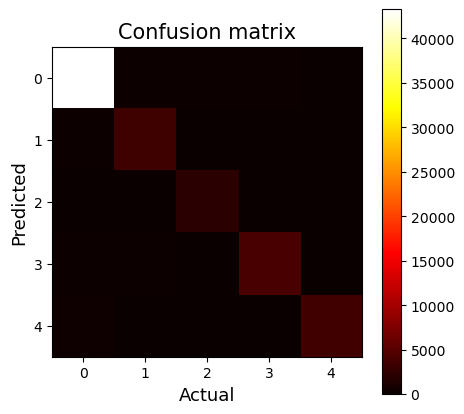

val mode | time: 15:29:01
completed metrics calc
loss: 0.9291858071262397, accuracy: 0.9916754086446166, f1: 0.9766439126581503, precision: 0.9757017999252533, recall: 0.9833587433652595


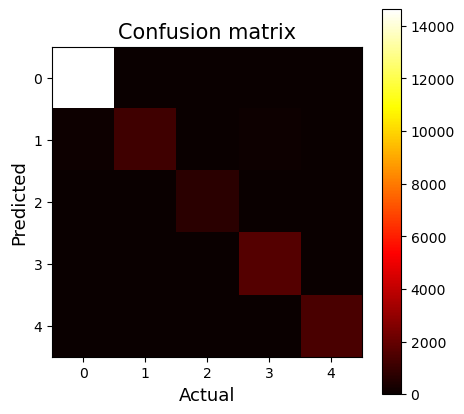


New checkpoint

train mode | time: 15:29:18
completed metrics calc
loss: 0.9193939599351467, accuracy: 0.9919224555735057, f1: 0.9824786259580639, precision: 0.9814737518391655, recall: 0.9868203807192885


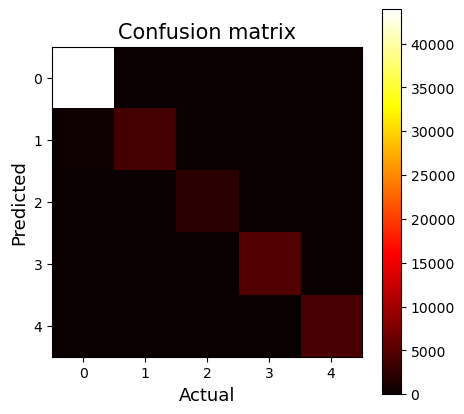

val mode | time: 15:32:03
completed metrics calc
loss: 0.9212382768543022, accuracy: 0.9948610882562674, f1: 0.9858880359533948, precision: 0.9804253237455774, recall: 0.9953717790049342


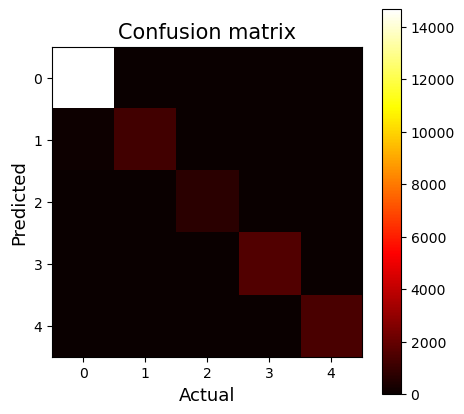


New checkpoint

train mode | time: 15:32:19
completed metrics calc
loss: 0.9149885245979507, accuracy: 0.9948000807754447, f1: 0.9883004613616513, precision: 0.9887167672192679, recall: 0.9900654762154711


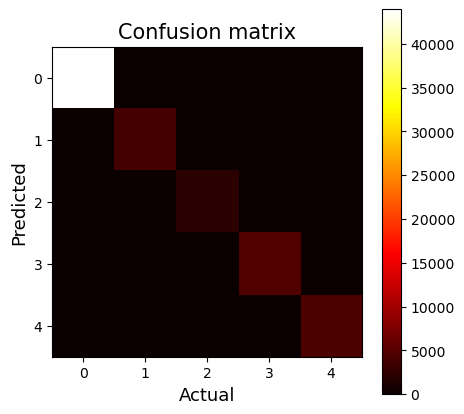

val mode | time: 15:34:58
completed metrics calc
loss: 0.9171520636498349, accuracy: 0.9980279126213601, f1: 0.9901018027494748, precision: 0.9881686411823102, recall: 0.9953205792804464


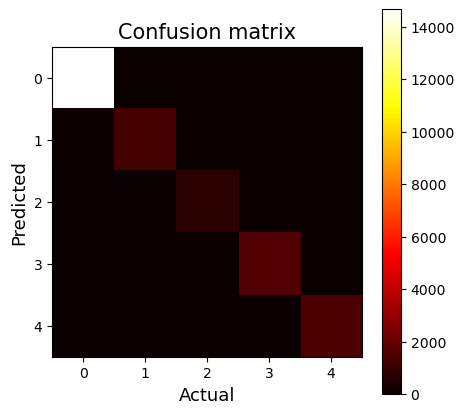


New checkpoint

train mode | time: 15:35:14
completed metrics calc
loss: 0.9127237224809958, accuracy: 0.9962809639203016, f1: 0.9912690462866274, precision: 0.9911443929121501, recall: 0.9931912768281193


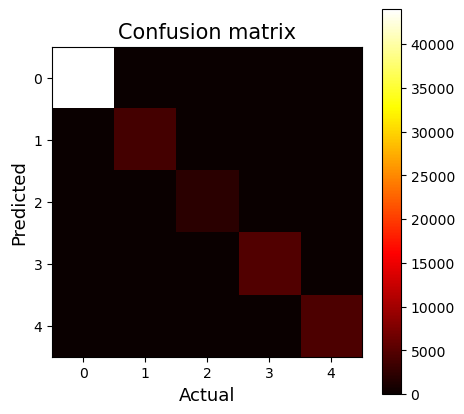

val mode | time: 15:37:55
completed metrics calc
loss: 0.9145638893530207, accuracy: 1.000676217706106, f1: 0.9964876374626319, precision: 0.9967657366882173, recall: 0.998354318338772


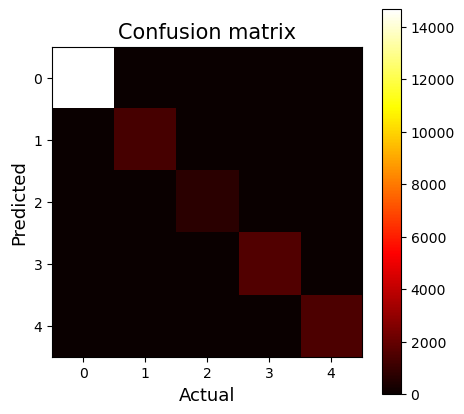

train mode | time: 15:38:12
completed metrics calc
loss: 0.9107482291770097, accuracy: 0.9980142703284874, f1: 0.9949288973859021, precision: 0.994246392402899, recall: 0.9967648618295001


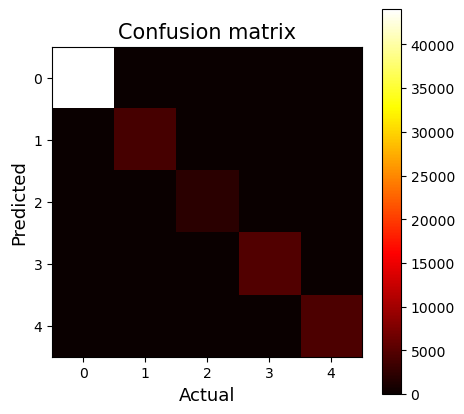

val mode | time: 15:40:52
completed metrics calc
loss: 0.9145714611683077, accuracy: 1.0001516990291268, f1: 0.9959562161621788, precision: 0.9954640116188408, recall: 0.9985368556030186


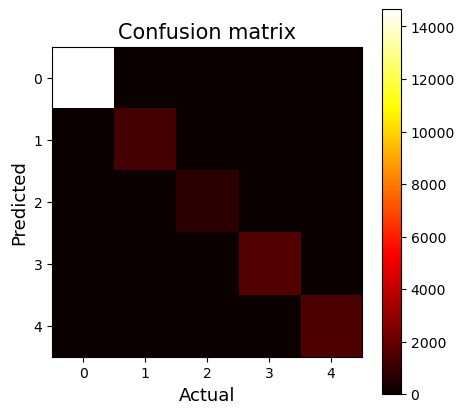


New checkpoint

train mode | time: 15:41:08
completed metrics calc
loss: 0.9098376660624306, accuracy: 0.9986537425955843, f1: 0.9960528099990662, precision: 0.9955580000053785, recall: 0.9975376386115754


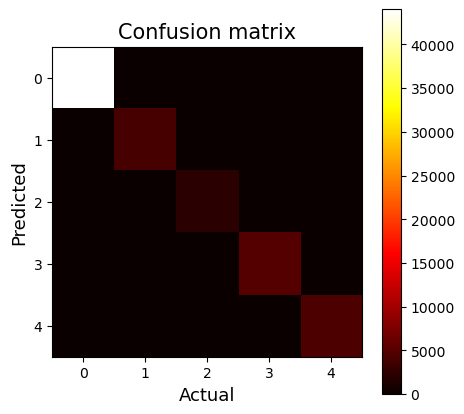

val mode | time: 15:43:49
completed metrics calc
loss: 0.9135672713367684, accuracy: 1.0007079288025895, f1: 0.9970446668301184, precision: 0.9974765647007106, recall: 0.9985289678354894


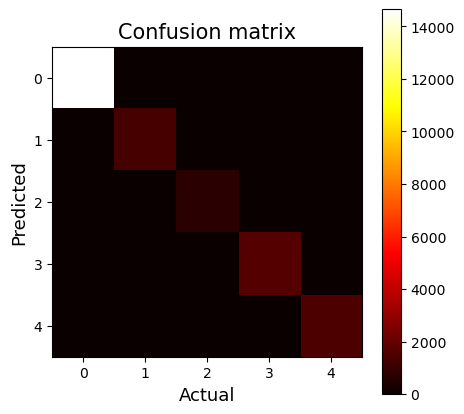

train mode | time: 15:44:04
completed metrics calc
loss: 0.9087312355372748, accuracy: 0.9995961227786753, f1: 0.9976964295509704, precision: 0.9972024737969065, recall: 0.9989305221361184


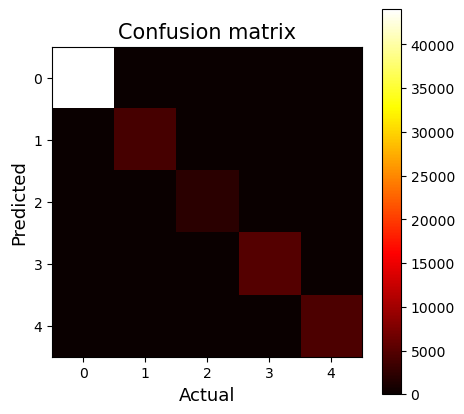

val mode | time: 15:46:45
completed metrics calc
loss: 0.9125342111564377, accuracy: 1.0018709546925573, f1: 0.9987830084179001, precision: 0.9983579097818843, recall: 1.000976600144214


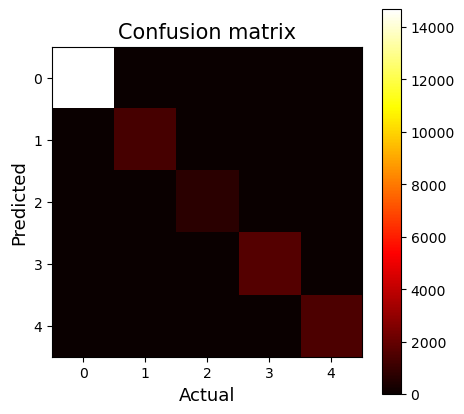

train mode | time: 15:47:01
completed metrics calc
loss: 0.9081076052346791, accuracy: 1.0002355950457722, f1: 0.9991104324099987, precision: 0.9985899314029896, recall: 1.0000712404218484


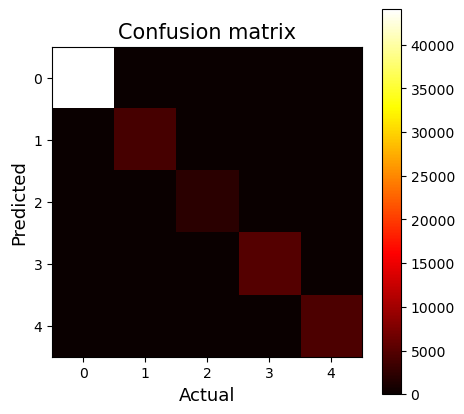

val mode | time: 15:49:42
completed metrics calc
loss: 0.9122585677406163, accuracy: 1.0021237864077677, f1: 0.9991164182130567, precision: 0.9987837651824394, recall: 1.0011693549240053


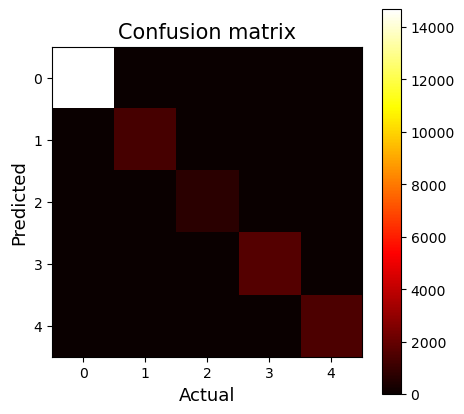

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|     conv1.conv_1.weight      |    640     |
|      conv1.conv_1.bias       |    128     |
|     conv1.conv_2.weight      |   81920    |
|      conv1.conv_2.bias       |    128     |
|     conv1.conv_3.weight      |   81920    |
|      conv1.conv_3.bias       |    128     |
| conv1.normalization_1.weight |    128     |
|  conv1.normalization_1.bias  |    128     |
| conv1.normalization_2.weight |    128     |
|  conv1.normalization_2.bias  |    128     |
| conv1.normalization_3.weight |    128     |
|  conv1.normalization_3.bias  |    128     |
|     conv2.conv_1.weight      |   40960    |
|      conv2.conv_1.bias       |     64     |
|     conv2.conv_2.weight      |   20480    |
|      conv2.conv_2.bias       |     64     |
|     conv2.conv_3.weight      |   20480    |
|      conv2.conv_3.bias       |     64     |
| conv2.normalization_1.weight |  

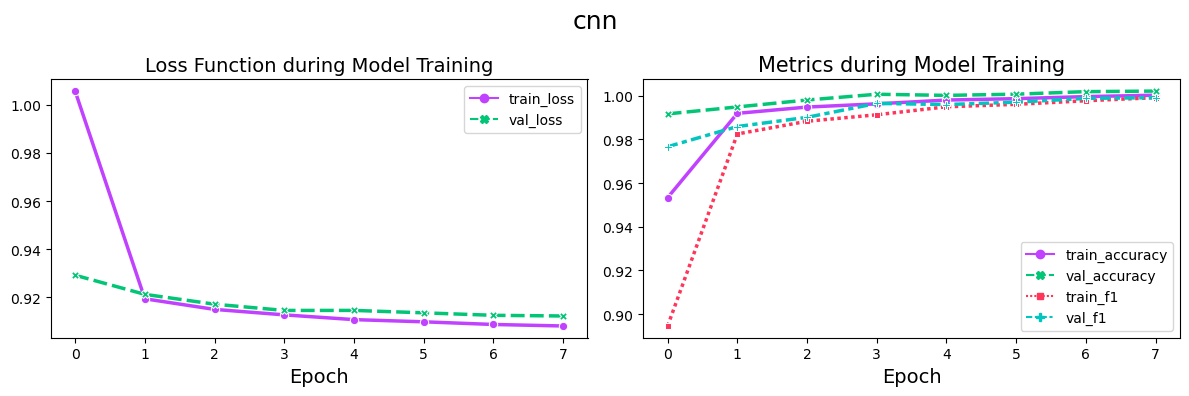

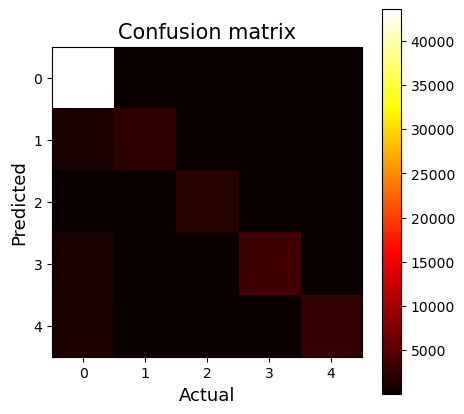

val mode | time: 15:51:26
completed metrics calc
loss: 0.9525291448079266, accuracy: 0.9620812421150782, f1: 0.9172876029925534, precision: 0.9128224568824084, recall: 0.9408143027662367


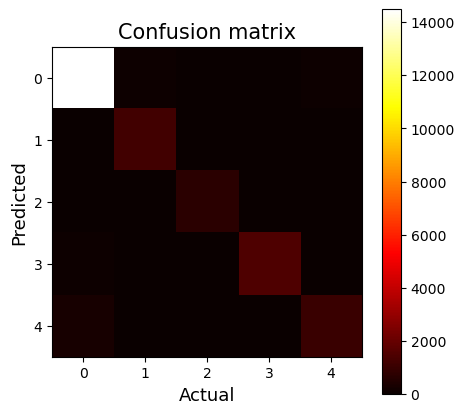


New checkpoint

train mode | time: 15:51:35
completed metrics calc
loss: 0.9411001192926398, accuracy: 0.9669493807215938, f1: 0.9292797753976076, precision: 0.9129069992210976, recall: 0.965164533290373


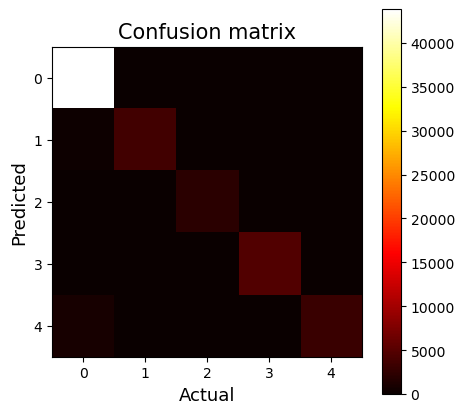

val mode | time: 15:52:57
completed metrics calc
loss: 0.9416819617007542, accuracy: 0.9721756554769353, f1: 0.9350974000566341, precision: 0.9249399163450628, recall: 0.967812831440175


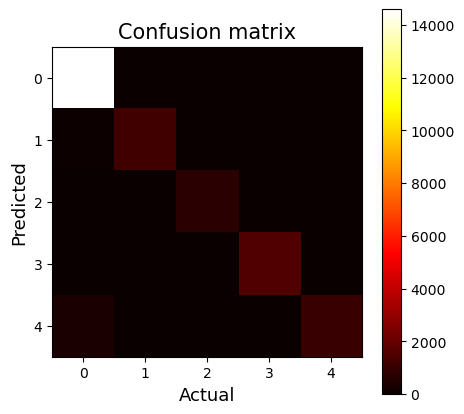


New checkpoint

train mode | time: 15:53:07
completed metrics calc
loss: 0.9344367410909379, accuracy: 0.9735460420032319, f1: 0.9403495132237476, precision: 0.9300311927457271, recall: 0.9670488316572239


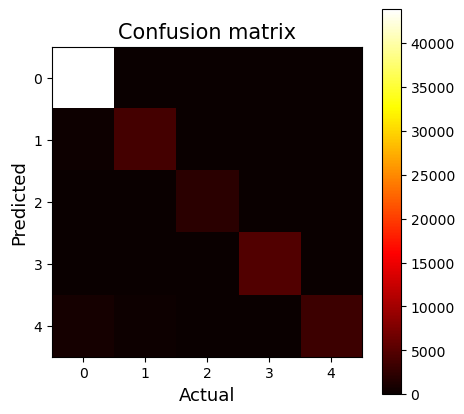

val mode | time: 15:54:28
completed metrics calc
loss: 0.9371122156532066, accuracy: 0.9767266263507217, f1: 0.9444394455477028, precision: 0.933341701945806, recall: 0.9753869005947974


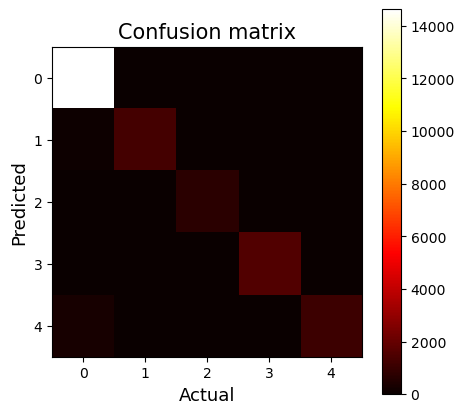

train mode | time: 15:54:38
completed metrics calc
loss: 0.9322700991576631, accuracy: 0.9757168820678518, f1: 0.9464123452974427, precision: 0.9338526821885073, recall: 0.9749374246526127


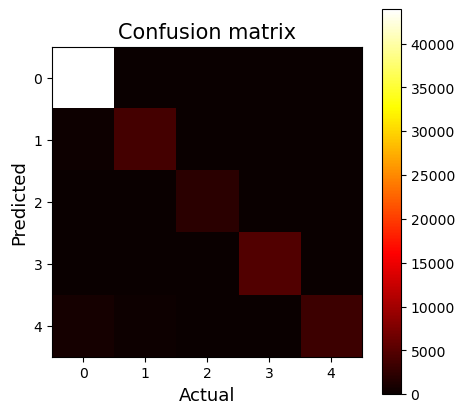

val mode | time: 15:55:58
completed metrics calc
loss: 0.9354417037616656, accuracy: 0.9785470147002365, f1: 0.9493611219995973, precision: 0.9397361236048284, recall: 0.9777398773152192


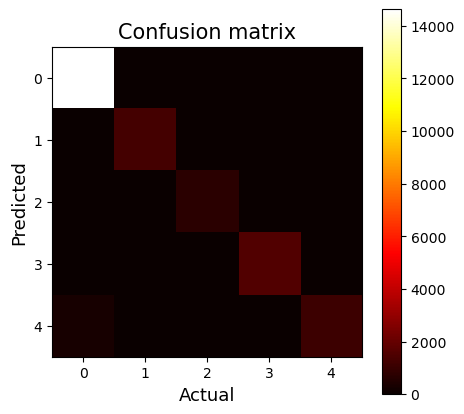


New checkpoint

train mode | time: 15:56:08
completed metrics calc
loss: 0.9299712597072028, accuracy: 0.9778540656973603, f1: 0.9490193717177452, precision: 0.9381179037618074, recall: 0.9754189716559624


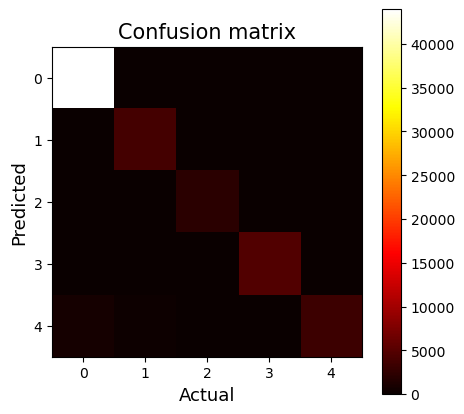

val mode | time: 15:57:27
completed metrics calc
loss: 0.9348311652836291, accuracy: 0.979052678130657, f1: 0.940726587284977, precision: 0.9402880631109145, recall: 0.9630580173913249


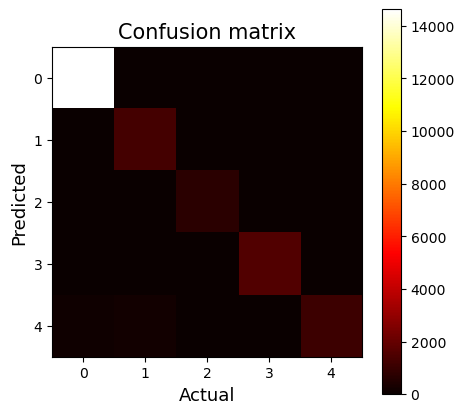

train mode | time: 15:57:37
completed metrics calc
loss: 0.9286283890149513, accuracy: 0.9792844641895527, f1: 0.9498163067211571, precision: 0.9403597029954563, recall: 0.97465064092282


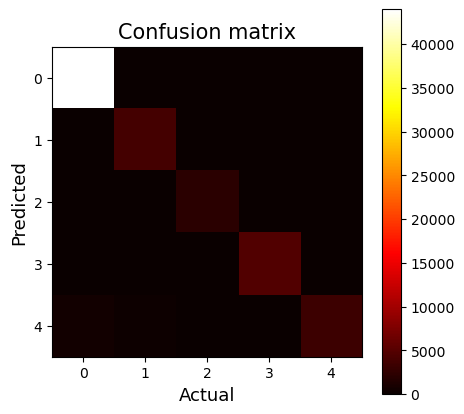

val mode | time: 15:58:56
completed metrics calc
loss: 0.9342380898091399, accuracy: 0.9793560761889095, f1: 0.9376645269998324, precision: 0.9419106832509392, recall: 0.9564120194224514


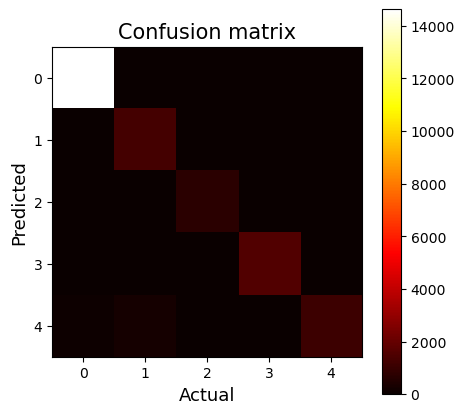

train mode | time: 15:59:06
completed metrics calc
loss: 0.927691554792093, accuracy: 0.9800585621970923, f1: 0.9477265997459755, precision: 0.9418651999542704, recall: 0.9702093031089791


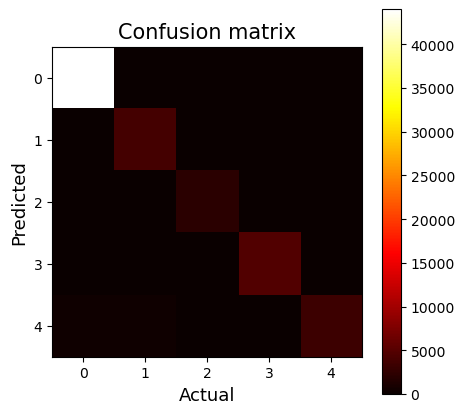

val mode | time: 16:00:26
completed metrics calc
loss: 0.9334832551409897, accuracy: 0.9802662703636669, f1: 0.9468370880892559, precision: 0.9418208221762939, recall: 0.9717552383996544


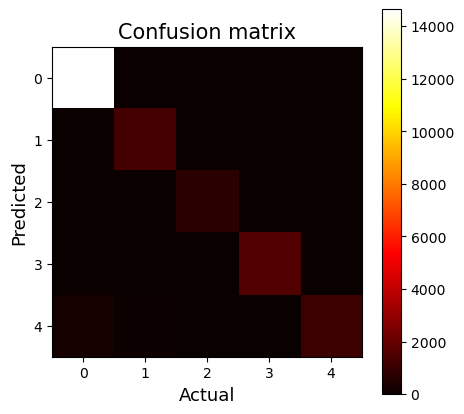

train mode | time: 16:00:35
completed metrics calc
loss: 0.9270981851610113, accuracy: 0.9806138933764139, f1: 0.949441947087205, precision: 0.9432408006602792, recall: 0.9714851326065743


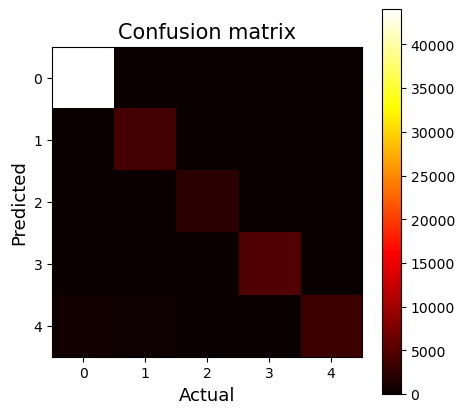

val mode | time: 16:01:59
completed metrics calc
loss: 0.9331457328449175, accuracy: 0.9805696684219193, f1: 0.9428968300590141, precision: 0.9418962465096398, recall: 0.9657235944290578


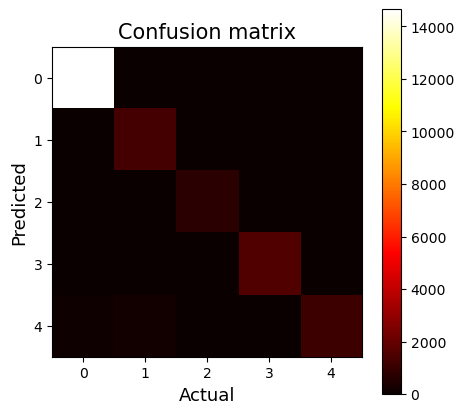

+----------------------------------+------------+
|             Modules              | Parameters |
+----------------------------------+------------+
| rnn_layer.rnn_layer.weight_ih_l0 |   12800    |
| rnn_layer.rnn_layer.weight_hh_l0 |   16384    |
|  rnn_layer.rnn_layer.bias_ih_l0  |    256     |
|  rnn_layer.rnn_layer.bias_hh_l0  |    256     |
|       conv1.conv_1.weight        |    320     |
|        conv1.conv_1.bias         |     64     |
|       conv1.conv_2.weight        |   20480    |
|        conv1.conv_2.bias         |     64     |
|       conv1.conv_3.weight        |   20480    |
|        conv1.conv_3.bias         |     64     |
|   conv1.normalization_1.weight   |     64     |
|    conv1.normalization_1.bias    |     64     |
|   conv1.normalization_2.weight   |     64     |
|    conv1.normalization_2.bias    |     64     |
|   conv1.normalization_3.weight   |     64     |
|    conv1.normalization_3.bias    |     64     |
|       conv2.conv_1.weight        |   20480    |


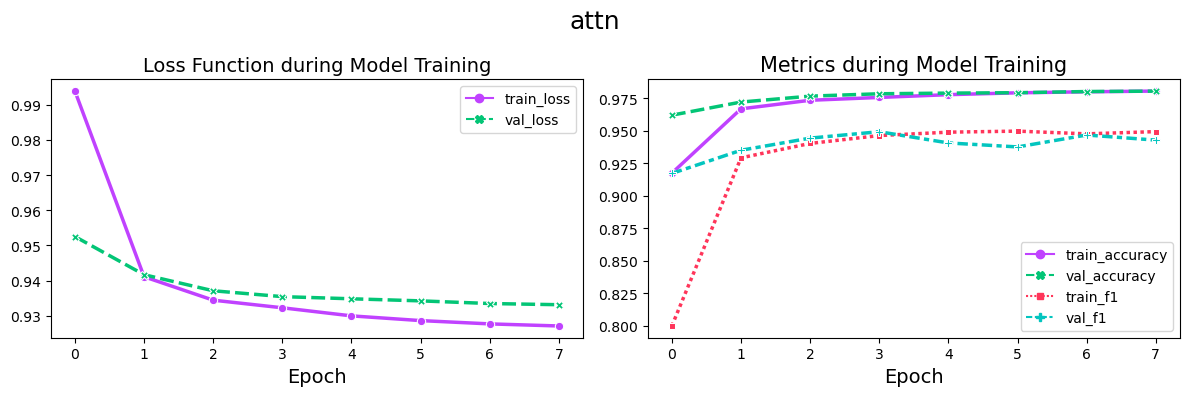

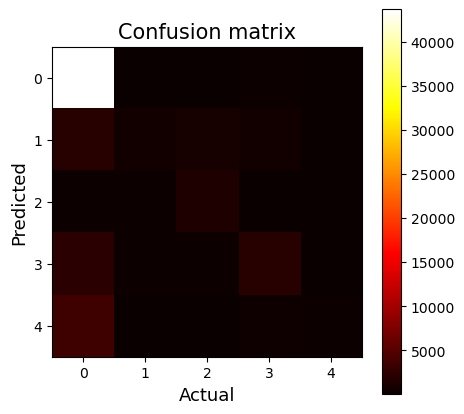

val mode | time: 16:03:53
completed metrics calc
loss: 1.0895651147782224, accuracy: 0.8218282047062694, f1: 0.44044352262942715, precision: 0.5098439145137299, recall: 0.8079798605309657


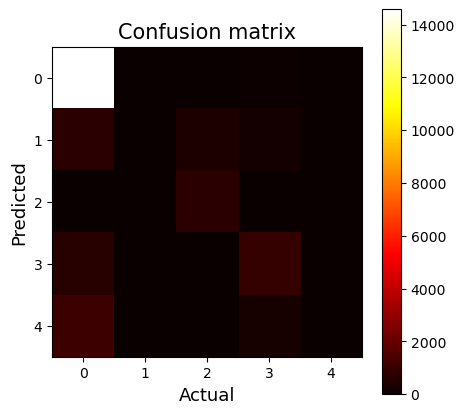


New checkpoint

train mode | time: 16:04:05
completed metrics calc
loss: 0.9927833207396968, accuracy: 0.9226373182552503, f1: 0.7934718967513991, precision: 0.7959002846169098, recall: 0.9090421721141216


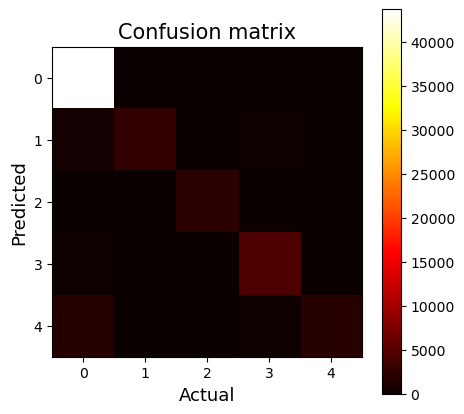

val mode | time: 16:05:45
completed metrics calc
loss: 0.9638667164497006, accuracy: 0.9571574515934396, f1: 0.8862958374679958, precision: 0.8885151608300998, recall: 0.9066998076006438


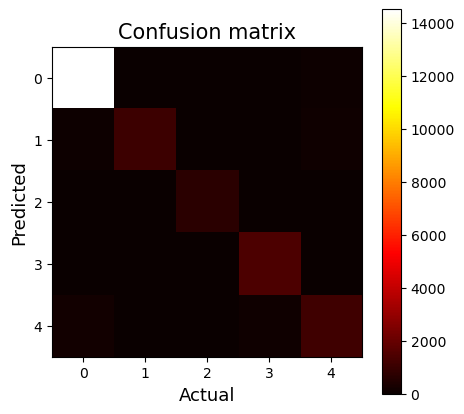


New checkpoint

train mode | time: 16:05:57
completed metrics calc
loss: 0.9344313026244883, accuracy: 0.9771977652127081, f1: 0.9469506226725644, precision: 0.942898939621048, recall: 0.9620421203097576


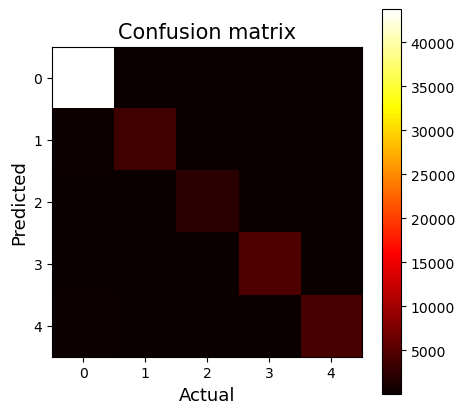

val mode | time: 16:07:34
completed metrics calc
loss: 0.9345726257967717, accuracy: 0.9821183698096646, f1: 0.9499064660446225, precision: 0.9493388474631722, recall: 0.9629521268000973


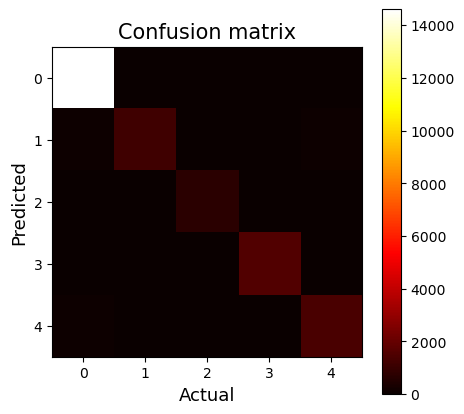


New checkpoint

train mode | time: 16:07:45
completed metrics calc
loss: 0.9258426337326864, accuracy: 0.9838785675821214, f1: 0.9624176090217249, precision: 0.9586680143159185, recall: 0.9744437727808415


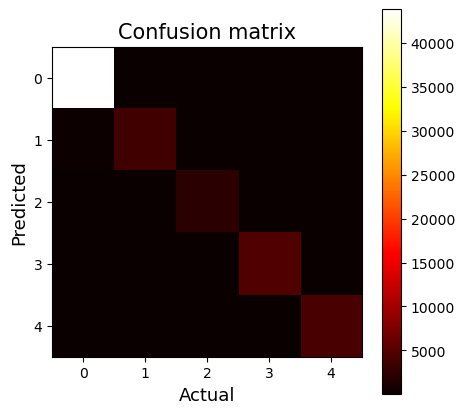

val mode | time: 16:09:21
completed metrics calc
loss: 0.9244744054322104, accuracy: 0.9910497572815542, f1: 0.9755024710503877, precision: 0.9696063031202, recall: 0.9875721295119338


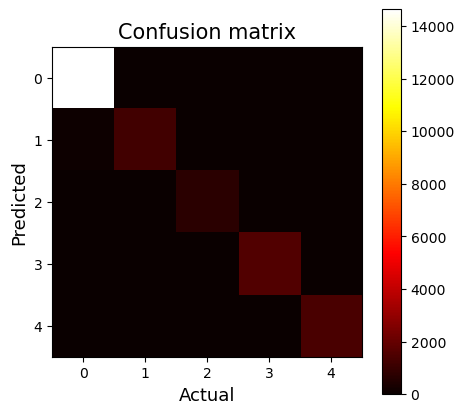


New checkpoint

train mode | time: 16:09:33
completed metrics calc
loss: 0.9223738209688991, accuracy: 0.986941303177168, f1: 0.96981832550273, precision: 0.9657963858089555, recall: 0.9801602419422722


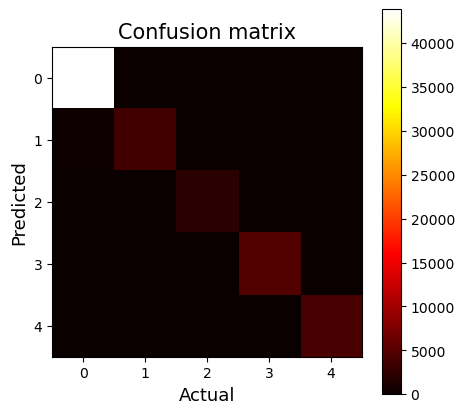

val mode | time: 16:11:11
completed metrics calc
loss: 0.9282479911174589, accuracy: 0.9872572815533979, f1: 0.9641135893079935, precision: 0.9597617413854801, recall: 0.9789007042319664


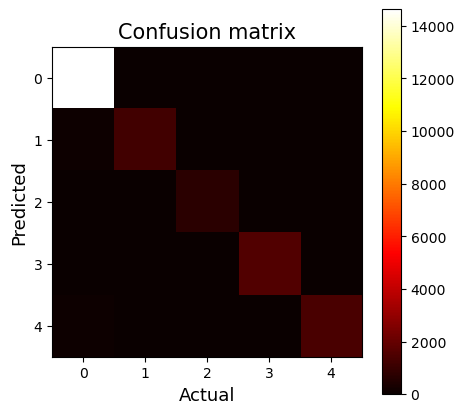


New checkpoint

train mode | time: 16:11:22
completed metrics calc
loss: 0.919922936906337, accuracy: 0.9888933764135702, f1: 0.9738236635184718, precision: 0.9709435301240227, recall: 0.9823135692943135


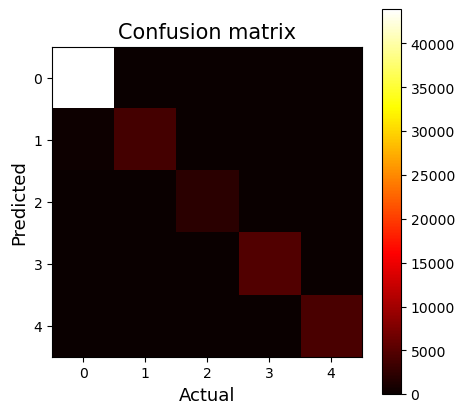

val mode | time: 16:12:59
completed metrics calc
loss: 0.9214963872455856, accuracy: 0.9934263754045315, f1: 0.9791976318221756, precision: 0.9782707193187936, recall: 0.986268493351363


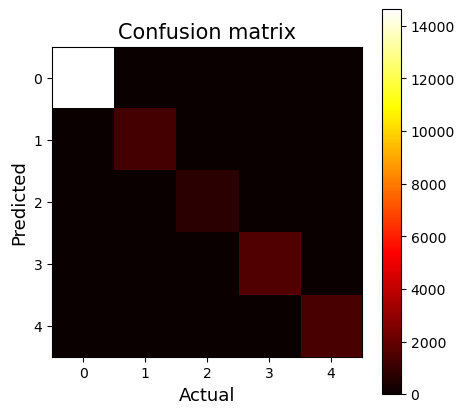

train mode | time: 16:13:10
completed metrics calc
loss: 0.9172077825073279, accuracy: 0.9918046580506186, f1: 0.9805639829841903, precision: 0.9768538899842331, recall: 0.9887498461852475


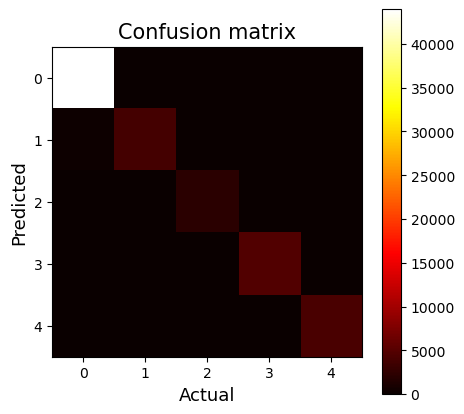

val mode | time: 16:14:49
completed metrics calc
loss: 0.9205042847151895, accuracy: 0.994336569579289, f1: 0.9819870021195152, precision: 0.9789821923094957, recall: 0.9909330723002512


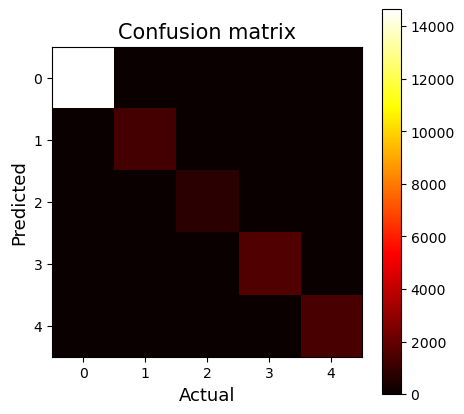

train mode | time: 16:15:01
completed metrics calc
loss: 0.9157023416389749, accuracy: 0.9931004308023692, f1: 0.9835452639259367, precision: 0.9801837425225903, recall: 0.9907477759084735


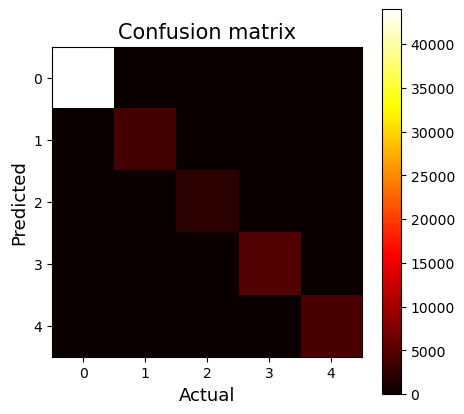

val mode | time: 16:16:40
completed metrics calc
loss: 0.9205240717211973, accuracy: 0.9941848705501626, f1: 0.981485973383251, precision: 0.9789137388289231, recall: 0.9899160088554185


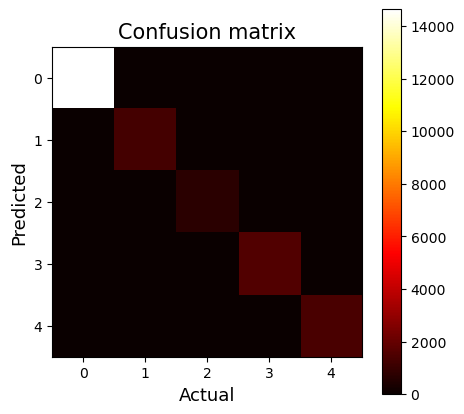


New checkpoint

+------------------------------------------+------------+
|                 Modules                  | Parameters |
+------------------------------------------+------------+
|     rnn_layer.rnn_layer.weight_ih_l0     |   12800    |
|     rnn_layer.rnn_layer.weight_hh_l0     |   16384    |
|      rnn_layer.rnn_layer.bias_ih_l0      |    256     |
|      rnn_layer.rnn_layer.bias_hh_l0      |    256     |
| rnn_layer.rnn_layer.weight_ih_l0_reverse |   12800    |
| rnn_layer.rnn_layer.weight_hh_l0_reverse |   16384    |
|  rnn_layer.rnn_layer.bias_ih_l0_reverse  |    256     |
|  rnn_layer.rnn_layer.bias_hh_l0_reverse  |    256     |
|           conv1.conv_1.weight            |    320     |
|            conv1.conv_1.bias             |     64     |
|           conv1.conv_2.weight            |   20480    |
|            conv1.conv_2.bias             |     64     |
|           conv1.conv_3.weight            |   20480    |
|            conv1.conv_3.bias             |     64    

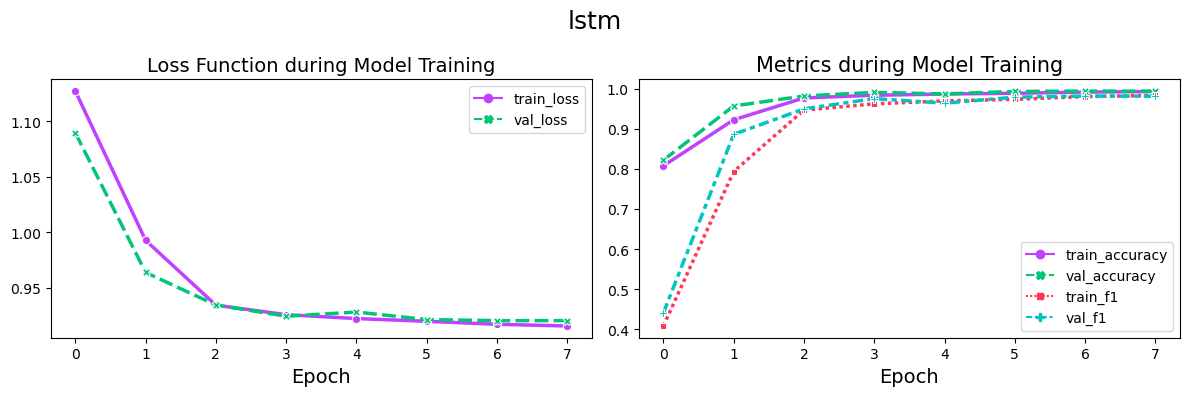

In [20]:

for model_nm, model in model_dict.items():
    n_model_logs_aggregator(model, model_nm)
    count_parameters(model)

In [21]:
## Testing

In [22]:
test_dataloader = get_dataloader(data_csv_path=config.test_csv_path, phase='test', batch_size =96)

In [23]:
def make_test_stage(dataloader, model, probs=False):
    cls_predictions = []
    cls_ground_truths = []

    for i, (data, cls_target) in enumerate(dataloader):
        with torch.no_grad():

            data = data.to(config.device)
            cls_target = cls_target.cpu()
            print(f"pred infer begins at: {time.strftime('%H:%M:%S')}")
            cls_prediction = model(data)
            print(f"pred infer ends at: {time.strftime('%H:%M:%S')}")
            
            if not probs:
                cls_prediction = torch.argmax(cls_prediction, dim=1)
    
            cls_predictions.append(cls_prediction.detach().cpu())
            cls_ground_truths.append(cls_target)

    predictions_cls = torch.cat(cls_predictions).numpy()
    ground_truths_cls = torch.cat(cls_ground_truths).numpy()
    return predictions_cls, ground_truths_cls

In [24]:
models = [m1, m3, m2]


In [25]:
y_pred, y_true = make_test_stage(test_dataloader, models[0])
y_pred.shape, y_true.shape

pred infer begins at: 16:16:55
pred infer ends at: 16:16:55
pred infer begins at: 16:16:55
pred infer ends at: 16:16:55
pred infer begins at: 16:16:55
pred infer ends at: 16:16:55
pred infer begins at: 16:16:55
pred infer ends at: 16:16:55
pred infer begins at: 16:16:55
pred infer ends at: 16:16:55
pred infer begins at: 16:16:55
pred infer ends at: 16:16:55
pred infer begins at: 16:16:55
pred infer ends at: 16:16:55
pred infer begins at: 16:16:55
pred infer ends at: 16:16:55
pred infer begins at: 16:16:55
pred infer ends at: 16:16:55
pred infer begins at: 16:16:55
pred infer ends at: 16:16:55
pred infer begins at: 16:16:55
pred infer ends at: 16:16:55
pred infer begins at: 16:16:55
pred infer ends at: 16:16:56
pred infer begins at: 16:16:56
pred infer ends at: 16:16:56
pred infer begins at: 16:16:56
pred infer ends at: 16:16:56
pred infer begins at: 16:16:56
pred infer ends at: 16:16:56
pred infer begins at: 16:16:56
pred infer ends at: 16:16:56
pred infer begins at: 16:16:56
pred infe

((19835,), (19835,))

In [26]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()

<Figure size 1400x600 with 0 Axes>

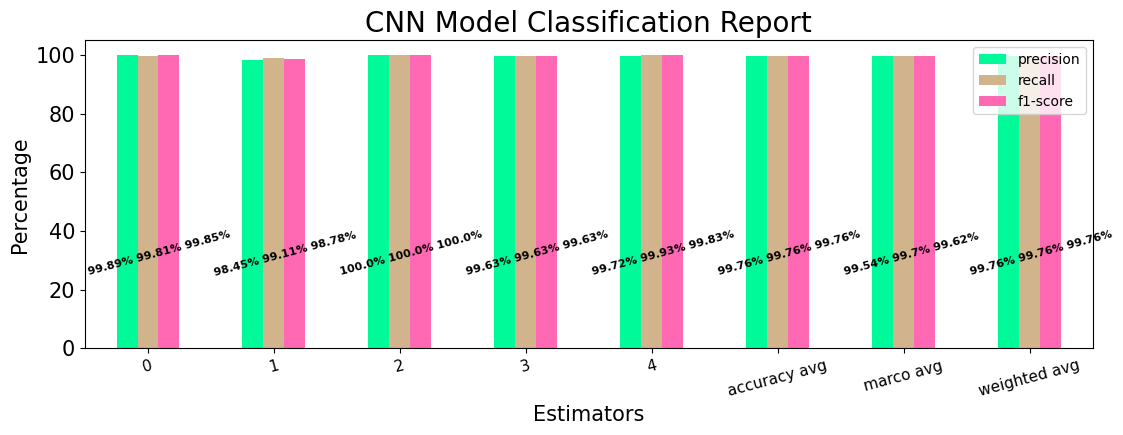

In [27]:
colors = ['#00FA9A', '#D2B48C', '#FF69B4']#random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)
report_plot = report.apply(lambda x: x*100)

fig = plt.figure(figsize=(14,6))

ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar',
                                                      figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(id_to_label.values())+["accuracy avg", "marco avg", "weighted avg"],
    rotation=15, fontsize=11)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("CNN Model Classification Report", fontsize=20)

for percentage, p in zip(
    report[['precision', 'recall', 'f1-score']].values,
    ax.patches):
    
    percentage = " ".join([str(round(i*100, 2))+"%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')
fig.savefig("cnn_report.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("cnn_report.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.show()

In [28]:
##cnn + lstm
y_pred, y_true = make_test_stage(test_dataloader, models[1])
y_pred.shape, y_true.shape

pred infer begins at: 16:17:10
pred infer ends at: 16:17:10
pred infer begins at: 16:17:10
pred infer ends at: 16:17:10
pred infer begins at: 16:17:10
pred infer ends at: 16:17:10
pred infer begins at: 16:17:10
pred infer ends at: 16:17:10
pred infer begins at: 16:17:10
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infer ends at: 16:17:11
pred infer begins at: 16:17:11
pred infe

((19835,), (19835,))

In [29]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()

<Figure size 1400x600 with 0 Axes>

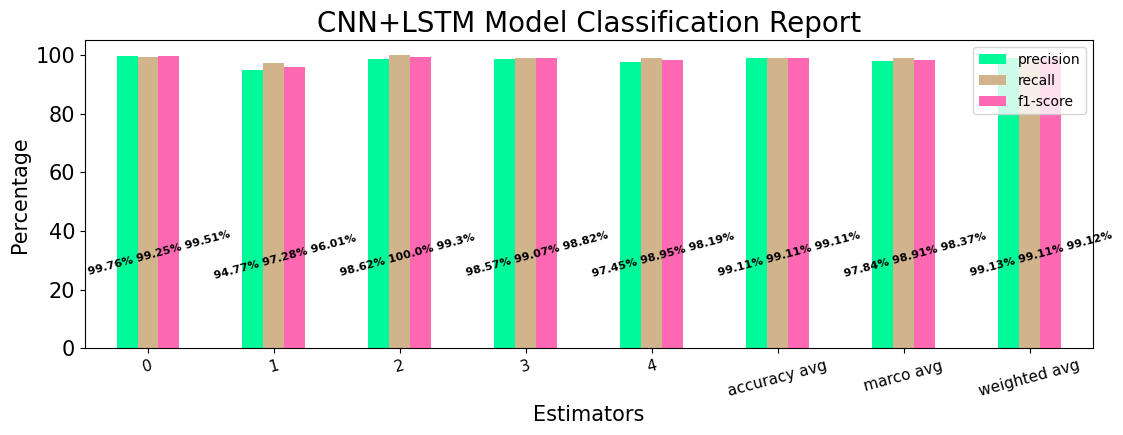

In [30]:
colors = ['#00FA9A', '#D2B48C', '#FF69B4']#random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)
report_plot = report.apply(lambda x: x*100)
fig = plt.figure(figsize=(14,6))

ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar',
                                                      figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(id_to_label.values())+["accuracy avg", "marco avg", "weighted avg"],
    rotation=15, fontsize=11)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("CNN+LSTM Model Classification Report", fontsize=20)

for percentage, p in zip(
    report[['precision', 'recall', 'f1-score']].values,
    ax.patches):
    
    percentage = " ".join([str(round(i*100, 2))+"%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')
fig.savefig("lstm_report.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("lstm_report.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.show()

In [31]:
## cnn + lstm +attn
y_pred, y_true = make_test_stage(test_dataloader, models[2])
y_pred.shape, y_true.shape

pred infer begins at: 16:17:21
pred infer ends at: 16:17:21
pred infer begins at: 16:17:21
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infer ends at: 16:17:22
pred infer begins at: 16:17:22
pred infe

((19835,), (19835,))

In [32]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()

<Figure size 1400x600 with 0 Axes>

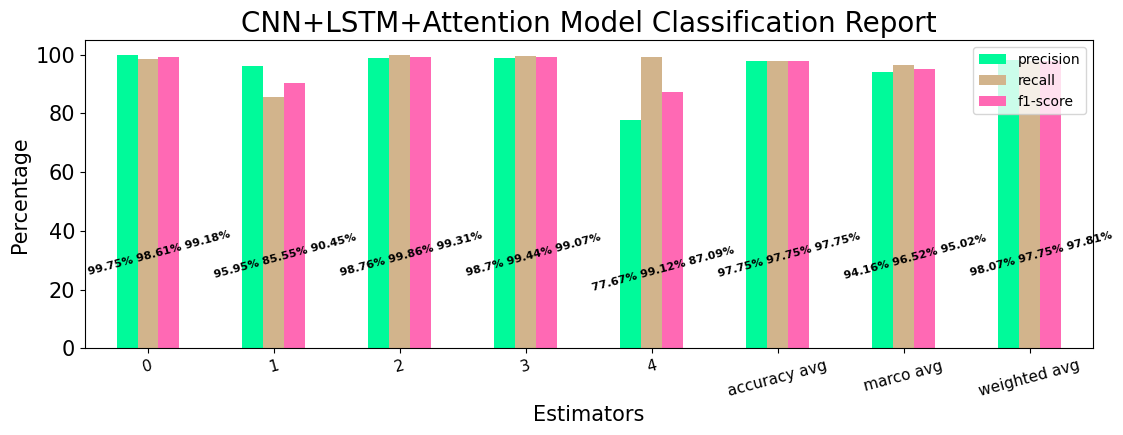

In [33]:
colors = ['#00FA9A', '#D2B48C', '#FF69B4']#random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)
report_plot = report.apply(lambda x: x*100)

fig = plt.figure(figsize=(14,6))
ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar',
                                                      figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(id_to_label.values())+["accuracy avg", "marco avg", "weighted avg"],
    rotation=15, fontsize=11)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("CNN+LSTM+Attention Model Classification Report", fontsize=20)

for percentage, p in zip(
    report[['precision', 'recall', 'f1-score']].values,
    ax.patches):
    
    percentage = " ".join([str(round(i*100, 2))+"%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')
fig.savefig("attn_report.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("attn_report.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.show()

In [34]:
## Ensemble
y_pred = np.zeros((y_pred.shape[0], 5), dtype=np.float32)
for i, model in enumerate(models, 1):
    y_pred_, y_true = make_test_stage(test_dataloader, model, True)
    y_pred += y_pred_
y_pred /= i
y_pred = np.argmax(y_pred, axis=1)

pred infer begins at: 16:17:30
pred infer ends at: 16:17:30
pred infer begins at: 16:17:30
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:31
pred infer begins at: 16:17:31
pred infer ends at: 16:17:32
pred infer begins at: 16:17:32
pred infe

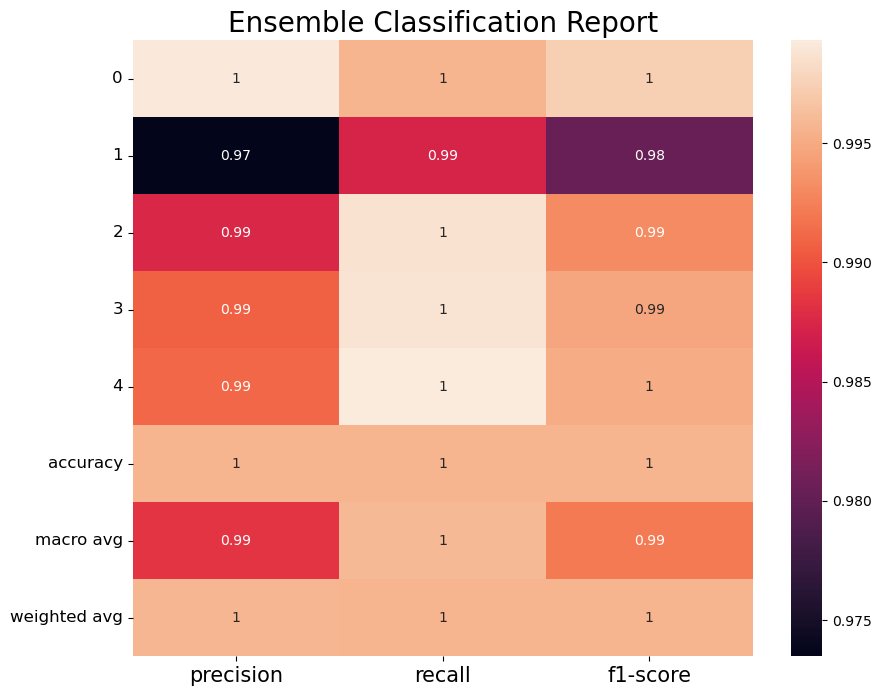

In [35]:
clf_report = classification_report(y_pred, 
                                   y_true,
                                   labels=[0,1,2,3,4],
                                   target_names=list(id_to_label.values()),#['N', 'S', 'V', 'F', 'Q'],
                                   output_dict=True)


plt.figure(figsize=(10, 8))
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=12, rotation=0)
plt.title("Ensemble Classification Report", fontsize=20)
plt.savefig(f"ensemble result.svg",format="svg",bbox_inches='tight', pad_inches=0.2)
plt.savefig(f"ensemble result.png", format="png",bbox_inches='tight', pad_inches=0.2)

In [36]:
clf_report

{0: {'precision': 0.9991149237472767,
  'recall': 0.9955902306648575,
  'f1-score': 0.9973494630963707,
  'support': 14740},
 1: {'precision': 0.9734904270986745,
  'recall': 0.9873039581777446,
  'f1-score': 0.9803485354097146,
  'support': 1339},
 2: {'precision': 0.9875690607734806,
  'recall': 0.9986033519553073,
  'f1-score': 0.9930555555555556,
  'support': 716},
 3: {'precision': 0.9907063197026023,
  'recall': 0.9987507807620237,
  'f1-score': 0.9947122861586314,
  'support': 1601},
 4: {'precision': 0.9910406616126809,
  'recall': 0.9993050729673384,
  'f1-score': 0.9951557093425605,
  'support': 1439},
 'accuracy': 0.9956642298966474,
 'macro avg': {'precision': 0.988384278586943,
  'recall': 0.9959106789054543,
  'f1-score': 0.9921243099125666,
  'support': 19835},
 'weighted avg': {'precision': 0.9957038283508096,
  'recall': 0.9956642298966474,
  'f1-score': 0.9956747662523722,
  'support': 19835}}